In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import emcee
sb.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
from models_EF import *

In [3]:
Ener,no_events,el,er = np.loadtxt('number_of_events.txt',unpack=True)

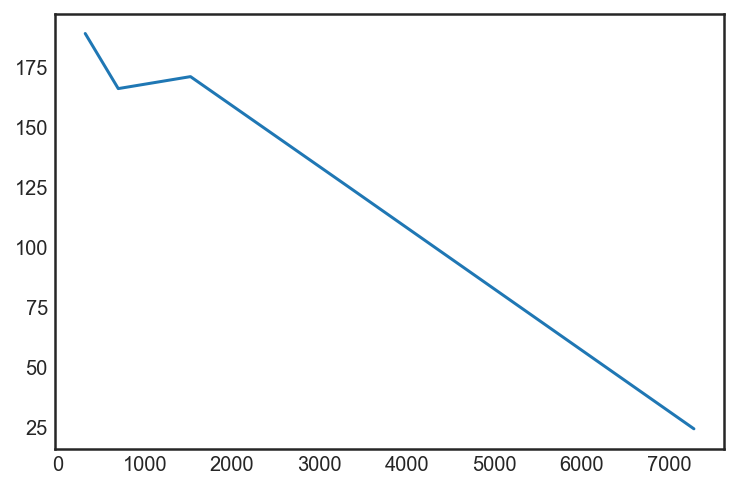

In [4]:
plt.plot(Ener,no_events);

In [5]:
print no_events

[189. 166. 171. 125.  24.]


In [6]:
e_min = Ener - el
e_max = Ener + er

In [7]:
print e_min
print e_max

[ 200.          437.34484863  956.35247803 2091.27905273 4573.05029297]
[  437.34484863   956.35247803  2091.27905273  4573.05029297
 10000.        ]


In [8]:
from scipy import optimize as op

In [9]:
fun2 = lambda *args: -event_lnhood(*args)

In [10]:
mid_2 = [1.,3.,-2.,3.,1.5]
bnds_2 = ((-2.,2.), (2.,4.), (-9.,2.),(-1.,6.),(0.,3.))

In [11]:
result2 = op.minimize(fun2, mid_2, args=(no_events,e_min,e_max,'p+b',None,None,None),method = 'TNC',bounds=bnds_2)

In [12]:
print result2.x

[ 1.00102428  3.00466675 -2.40801064  2.49673798  1.15380927]


In [13]:
p_list_2 = [-2.,2., 2.,4.,-9.,2.,0.,6.,0.,3.]


In [14]:
nwalkers = 400
ndim = (len(p_list_2)/2) 

In [15]:
z = np.zeros((ndim,nwalkers))

In [16]:
h = 1e-2

pos_i=[]


for i in range(ndim):
    z[i,:] = result2.x[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i],z[4,i]]))

In [17]:
b_steps, steps = 1000, 3000

In [18]:
sampler = emcee.EnsembleSampler(nwalkers, ndim,event_lnpost, 
                                args=(no_events,e_min,e_max,'p+b',p_list_2,None,None,None),
                                threads = 2)

In [19]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps)

In [20]:
print sampler.acceptance_fraction.mean()

0.2923175


In [21]:
sampler.reset()

In [22]:
_,_,_=sampler.run_mcmc(pos, steps, rstate0=state)

In [23]:
print sampler.acceptance_fraction.mean()

0.35114333333333336


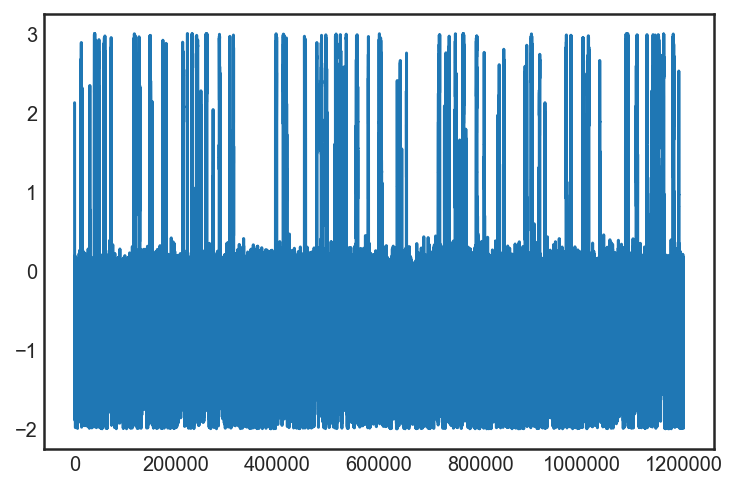

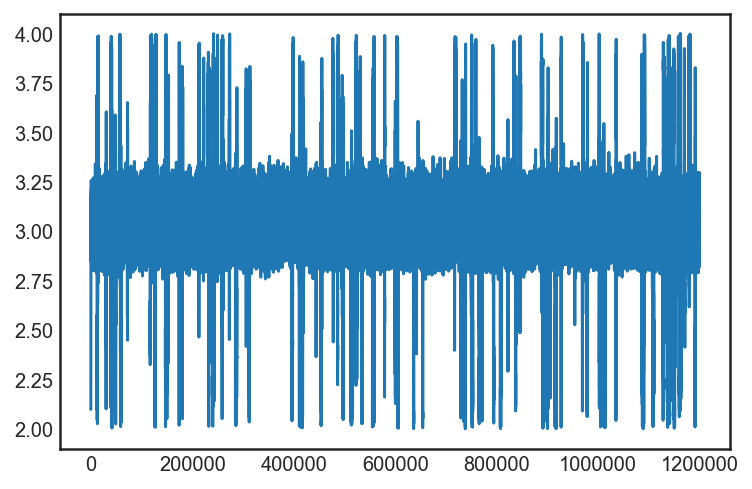

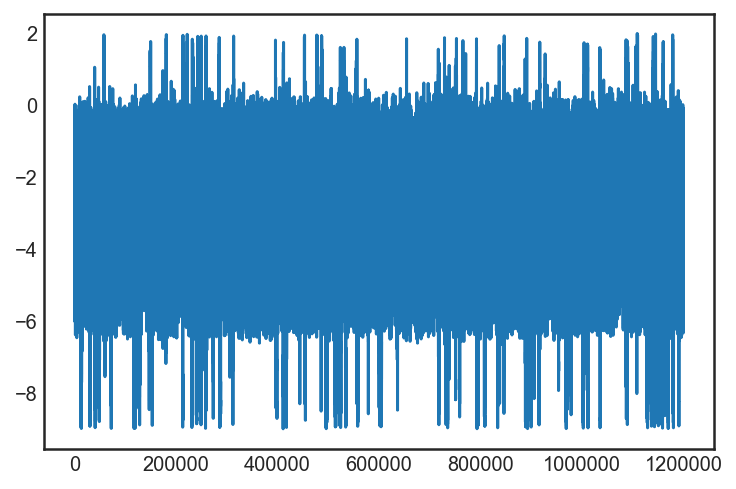

In [24]:
plt.figure()
plt.plot(sampler.flatchain[:,0]);
plt.figure()
plt.plot(sampler.flatchain[:,1]);
plt.figure()
plt.plot(sampler.flatchain[:,2]);

In [25]:
import corner as corner 

In [26]:
labels = [r'$\Gamma$',r'$log10(E_{cut})$','log10(N0)',r'$log10(N_N)$',r'$\alpha$']

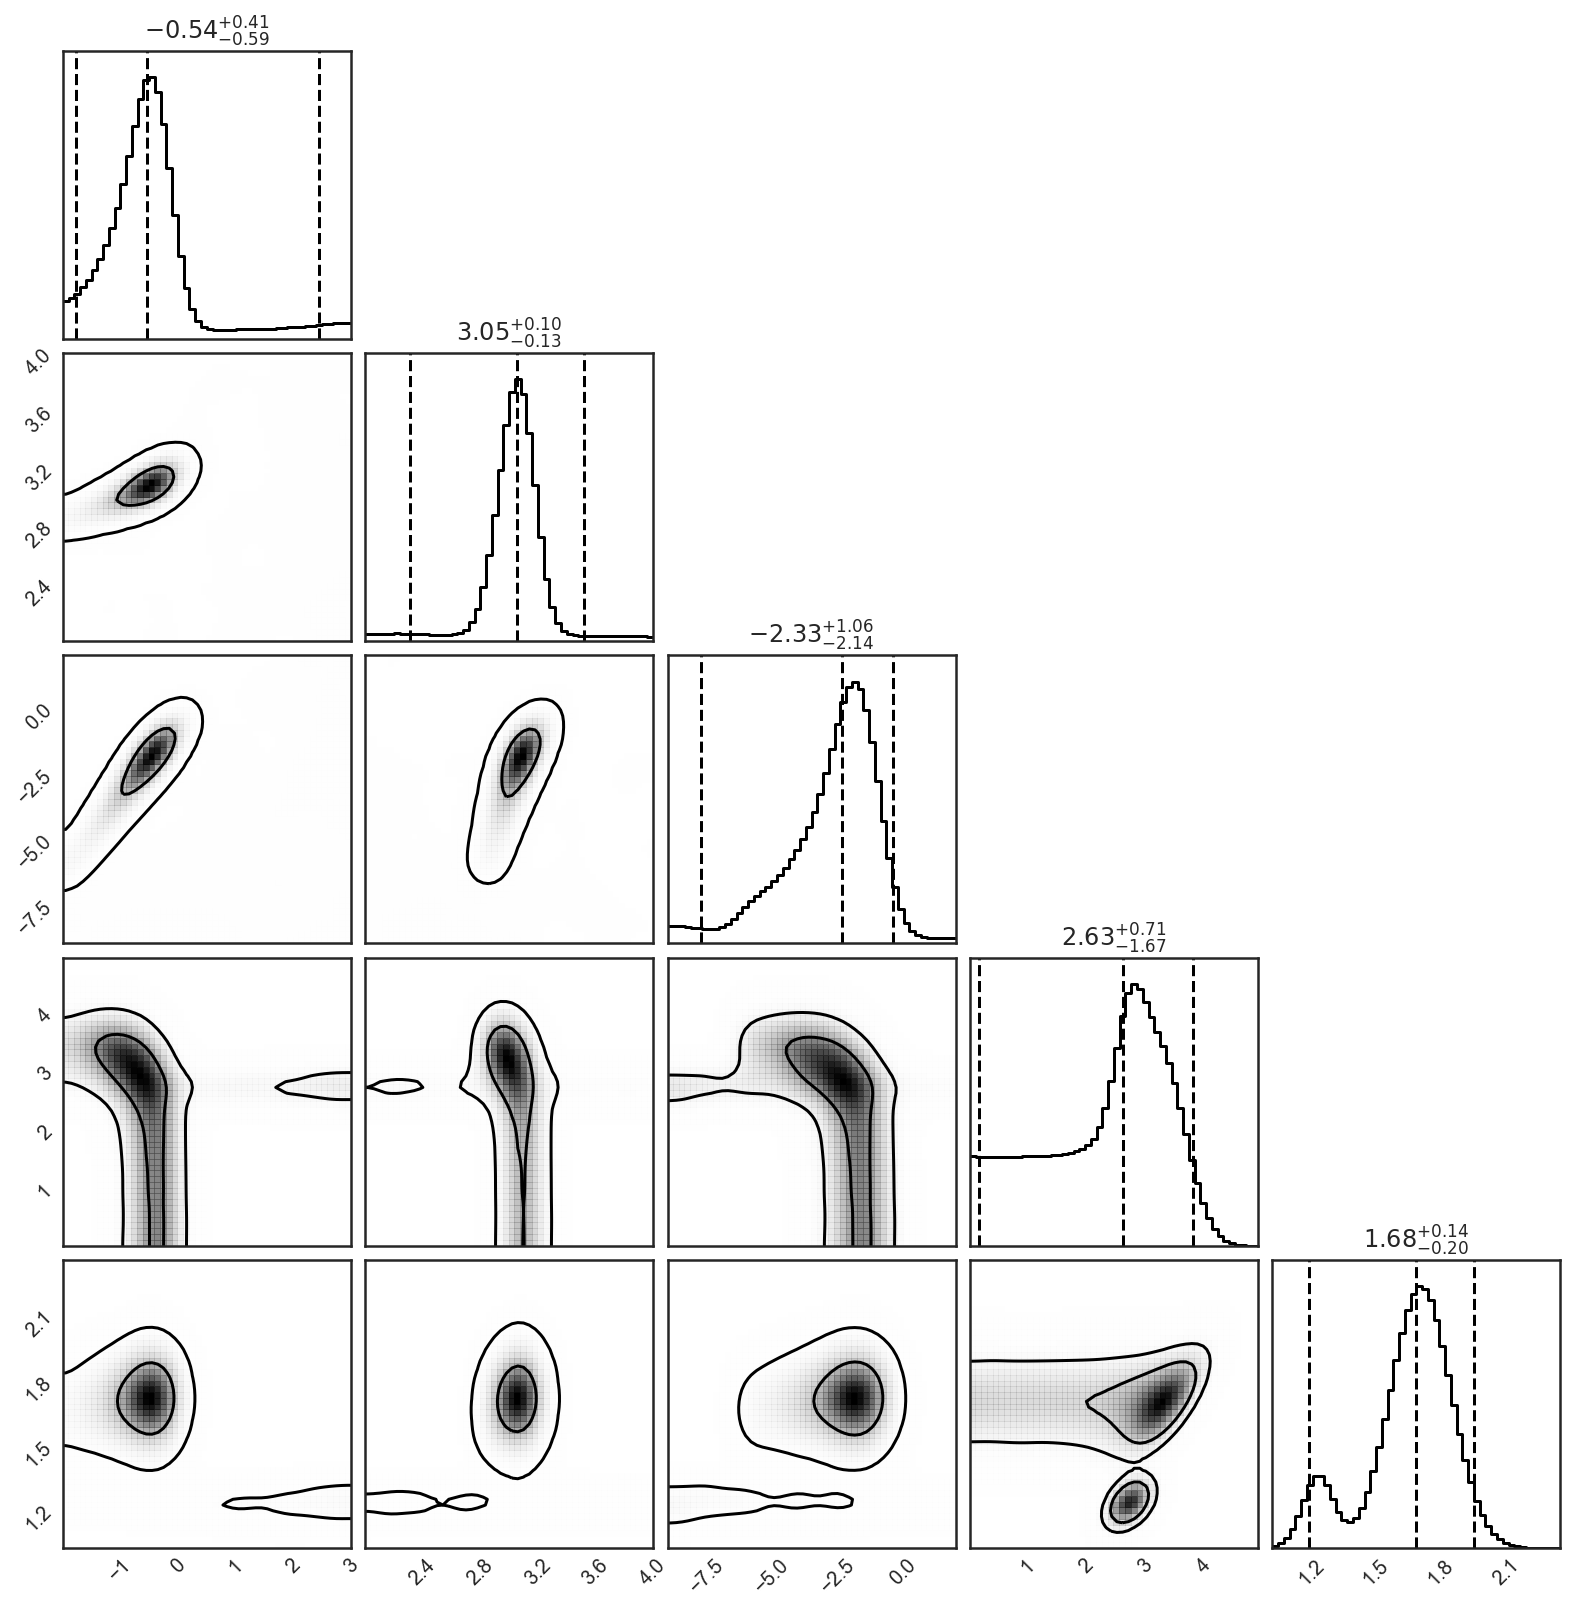

In [27]:
fig = corner.corner(sampler.flatchain,bins=50,plot_datapoints=False,smooth=2., 
                    smooth1d=2.,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

In [28]:
fig.savefig('data_events_complete.pdf')

In [29]:
events = no_events_model_pulsar([0.7,np.log10(2500.),1.4],e_min,e_max)

In [30]:
print events

[ 96.0220154  105.05946115  97.15344341  63.02214661  19.92431838]


In [31]:
10.**3.37

2344.228815319923

In [32]:
#np.savetxt('chains_events_wob.dat',sampler.flatchain)

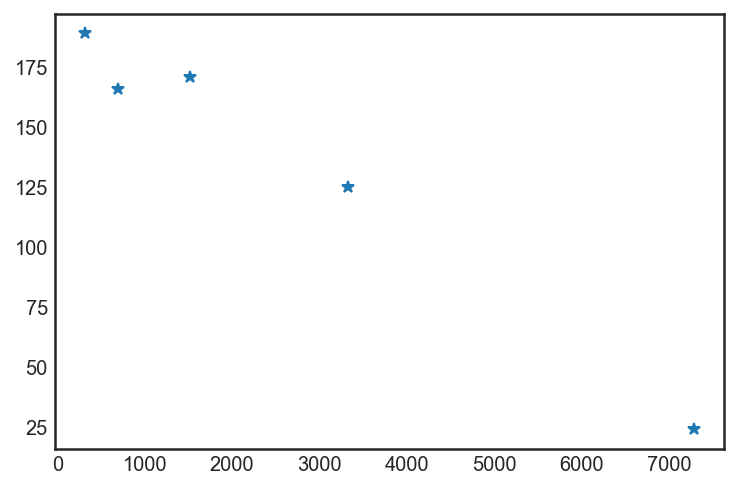

In [33]:
plt.plot(Ener,no_events,'*');

In [34]:
background = np.loadtxt('back_events.txt',usecols=(1),unpack=True)

In [35]:
#events_wo_back= np.loadtxt('number_of_events_bck.txt',usecols=1,unpack=True)

Text(0,0.5,u'No_Events')

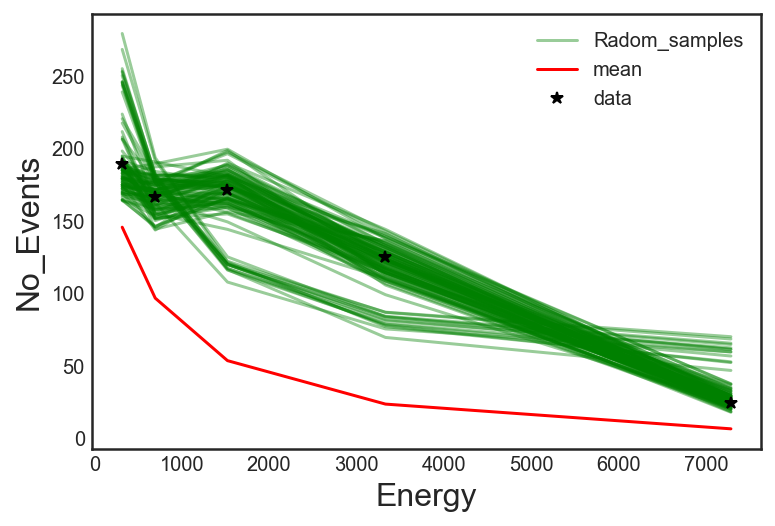

In [36]:
fig1 = plt.figure()

for c1,c2,c3,c4,c5 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    val_1 = no_events_pulsar_complete([c1,c2,c3,c4,c5],e_min,e_max)
    fig_1,=plt.plot(Ener,val_1,'g',alpha=0.4);

val1_mean = no_events_pulsar_complete([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2]),
                                   np.mean(sampler.flatchain[:,3]),np.mean(sampler.flatchain[:,4])],e_min,e_max)

fig_2,=plt.plot(Ener,val1_mean,'r');
#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_3,=plt.plot(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3],['Radom_samples','mean','data'],loc='best')
plt.xlabel('Energy',fontsize=16)
plt.ylabel('No_Events',fontsize=16)
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

In [37]:
print no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)

[ 4.02337512  8.83923137 13.04331257  8.64900846  1.28372336]


In [38]:
print no_events_model_pulsar([-.6,3.9,-2.29],e_min,e_max)

[  36.89893995  122.88137011  386.32918346 1072.38264656 2282.01815146]


In [39]:
np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])

(-0.45584035862435063, 3.0311117653503374, -2.7786234882775083)

In [40]:
print e_min

[ 200.          437.34484863  956.35247803 2091.27905273 4573.05029297]


In [41]:
print e_max

[  437.34484863   956.35247803  2091.27905273  4573.05029297
 10000.        ]


In [42]:
print background

[137.47350022  85.32183527  38.96453156  13.96934172   4.62096358]
